# Providing data driven suggestion for HR

### step[01] : Imports

In [16]:
# Import packages
### YOUR CODE HERE ### 

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

#### Load dataset

In [26]:
# Load data into dataframe
df0 = pd.read_csv("../data/HR_dataset.csv")

# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### step[02] : Data Exploration (initial EDA and data cleaning)

- Understand the variables
- Clean the dataset (missing data, redundant data, outliers)

#### Gather basic inforamtion about the data

In [28]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


#### Gather descriptive statistic about the data 

In [29]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


#### Rename columns 

As a data cleaning step, rename the columns as needed. Standardize the column names so that they are all in `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [30]:
# Display all column names

df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [31]:
df0 = df0.rename(columns={'Work_accident':'work_accident',
                          'average_montly_hours':'average_monthly_hours',
                          'time_spend_company':'tenure',
                          'Deoartment':'department'})

# Display all columns after update 
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

#### Check missing values

In [32]:
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

#### Check duplicates

In [33]:
df0.duplicated().sum()

np.int64(3008)

3,008 rows contain duplicates. That is 20% of the data.

In [34]:
# Inspect some rows containing duplicates as needed 
df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,Department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


The above output shows the first five occurences of rows that are duplicated farther down in the dataframe. How likely is it that these are legitimate entries? In other words, how plausible is it that two employees self-reported the exact same response for every column?

Perform a likelihood analysis by essentially applying Bayes' theorem and multiplying the probabilities of finding each value in each column, but this does not seem necessary. With several continuous variables across 10 columns, it seems very unlikely that these observations are legitimate. I can proceed by dropping them.

In [35]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates(keep='first')

# Display first few rows of new dataframe as needed
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


#### Check outliers

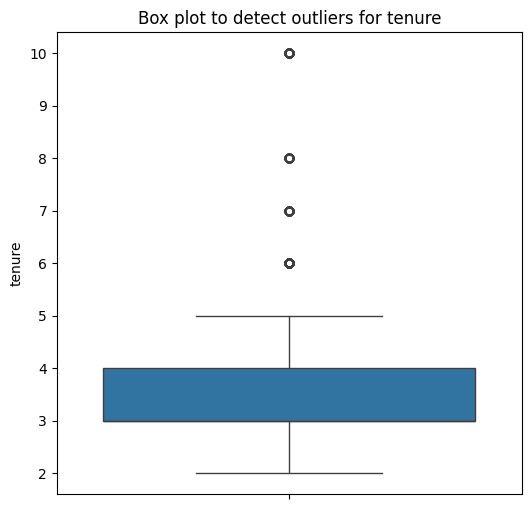

In [39]:
# Create box plot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize=(6,6))
plt.title("Box plot to detect outliers for tenure", fontsize=12)  
sns.boxplot(df1['tenure'])
plt.show()

The boxplot above shows that there are outliers in the `tenure` variable. 

It would be helpful to investigate how many rows in the data contain outliers in the `tenure` column.

In [42]:
# Determine the number of rows containing outliers.

# Compute the 25th percentile value in 'tenure' 
percentile25 = df1['tenure'].quantile(0.25)

# Compute the 75th percentile value in 'tenure' 
percentile75 = df1['tenure'].quantile(0.75)

# Compute the interquantile range in 'tenure' 
iqr = percentile75 - percentile25

# Define the upper and lower limit for non-outi;ers in 'tenure' 
upper_limit = percentile75 + (1.5*iqr)
lower_limit = percentile25 - (1.5*iqr)
print("Upper limit: ", upper_limit)
print("Lower_limit: ", lower_limit)

# Identify subset of containing outliers in 'tenure' 
outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

# Count how many rows in the data contain outliers in 'tenure' 
print("Number of rows in the data containing outliers:", len(outliers))


Upper limit:  5.5
Lower_limit:  1.5
Number of rows in the data containing outliers: 824


Certain types of models are more sensitive to outliers than others. When I get to the stage of building my model, consider whether to remove these outliers based on the type of model I decide to use.

## step[02] : Data Exploration (Continue EDA)

Begin by understanding how many employees left and what percentage of all employees this figure represents.

In [44]:
# Get the number of people who left vs stayed
print(df1['left'].value_counts())
print()

# Get the percentage of people who left vs. stayed
print(df1['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


#### Data visualizations

Now, examine variables that I am interested in, and create plots to visualize relationships between variables in the data.

I could start by creating a stacked boxplot showing `average_monthly_hours` distributions for `number_project`, comparing the distributions of employees who stayed versus those who left.

Box plots are very useful in visualizing distributions within data, but they can be deceiving without the context of how big the sample sizes that they represent are. So, I could also plot a stacked histogram to visualize the distribution of `number_project` for those who stayed and those who left.